<a href="https://colab.research.google.com/github/waleedGeorgy/deep-learning/blob/main/Deep_Learning_Research_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll try to replicate the research paper "**An Image Is Worth 16X16 Words: Transformers For Image Recognition At Scale**" - [Paper here](https://arxiv.org/abs/2010.11929)

# Setting up

In [88]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [90]:
data_path = download_data(source = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                          destination = 'pizza_steak_sushi')

data_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [91]:
train_dir = data_path / 'train'
test_dir = data_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Creating datasets and DataLoaders

- As described in the research paper, we'll try to replicate the ViT (vision transformer) architecture and apply it to our own problem.
- To start off, we'll need to resize the images to 224x224, and use a batch size of 4096.
- The former is easy to achieve but the latter may prove too much for the basic hardware provided by Google Colab. So, we'll stick to a batch size of 32.

In [92]:
# Creating the manual transform
from torchvision import transforms

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [93]:
# Creating the dataloaders
import os

BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = BATCH_SIZE,
                                                                               num_workers = os.cpu_count())

In [94]:
class_names, len(train_dataloader), len(test_dataloader)

(['pizza', 'steak', 'sushi'], 8, 3)

# Visualizing an image

In [95]:
# Getting a single batch from the train dataloader
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0], label_batch[0]

img.shape, label

(torch.Size([3, 224, 224]), tensor(0))

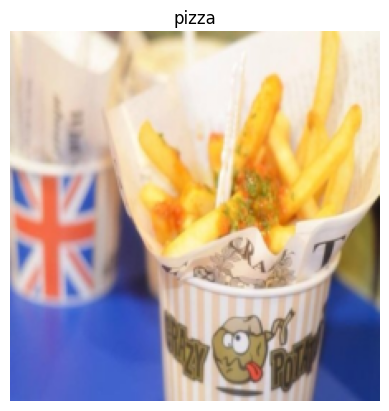

In [96]:
# Visualizing the img and labeling it
import matplotlib.pyplot as plt

plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.title(class_names[label]);

# Overview of the ViT

The ViT described in the paper can be broken down into these basic component:
- **INPUTS** - What goes into a layer / block / model? (e.g. batches of image tensors).
- **OUTPUTS** - What goes out of a layer / block / model? (e.g. classification labels & predictions).
- **LAYERS** - Take an input, and manipulate it with a mathmatical equation or function. (self-attention / multi-head attention, LayerNorm, etc...)
- **BLOCKS** - A group of layers.
- **MODEL** - A group of blocks.

## ViT in more detail
The components we'll need in order to build the model described in the research paper can be extracted from three main sources:

### Figure 1
Main model architecture (p. 3)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

[**Embeddings**](https://www.ibm.com/topics/embedding) are numerical representations of real-world objects that ML and AI systems use to understand complex knowledge domains like humans do. As an example, computing algorithms understand that the difference between 2 and 3 is 1, indicating a close relationship between 2 and 3 as compared to 2 and 100. However, real-world data includes more complex relationships. For example, a bird-nest and a lion-den are analogous pairs, while day-night are opposite terms. Embeddings convert real-world objects into complex mathematical representations that capture inherent properties and relationships between real-world data. The entire process is automated, with AI systems self-creating embeddings during training and using them as needed to complete new tasks.

---

### The Four Equations
The mathmatical representations of the layers in ViT (p. 4)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

- **Equations 1:**

The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathrm{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

[**What is a Transformer model?**](https://blogs.nvidia.com/blog/what-is-a-transformer-model/)

```
# Equation 1
x_input = [class_token, img_patch_1, img_patch_2, ..., img_patch_N] + [class_token_pos, img_patch_1_pos, img_patch_2_pos, ..., img_patch_N_pos]
```

- **Equation 2 & 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self-attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

**Layer normalization (LN)** computes the mean and standard deviation across each individual observation (over all channels in case of images) rather than across the batch. This makes it batch-size independent and can therefore be used in models like RNNs or in transformer models.

[**What is self-attention?**](https://h2o.ai/wiki/self-attention/)

[**What is multihead-attention?**](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)

[**Difference between Attention, Self-Attention and Multi-Head Attention?**](https://www.adityaagrawal.net/blog/deep_learning/attention)

```
# Equation 2:
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3:
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

The output of each block is a combination of the actual output of the block + the raw input of the same block using a residual connection.

**Residual connections** -  are links that connect some layers in a neural network to other layers that are not directly adjacent. For example, in a typical convolutional neural network (CNN), each layer receives input from the previous layer and passes output to the next layer. However, with residual connections, some layers can also receive input from or send output to layers that are several steps away. This creates a parallel path for information flow that bypasses some intermediate layers.


They work by adding the output of a previous layer to the input of a later layer. This means that the later layer does not have to learn the entire function that maps the input to the output, but only the residual or difference between them. For example, if the input is x and the output is y, then the layer with a residual connection only has to learn the function f(x) such that y = x + f(x). This makes the learning process easier and more stable, as the layer can simply learn an identity function f(x) = 0 if there is no difference between x and y.

Residual connections are beneficial for several reasons.
**First**, they help alleviate the problem of vanishing or exploding gradients, which occurs when the gradients of the loss function become too small or too large as they propagate back through the network. This can cause the network to stop learning or diverge. Residual connections allow the gradients to flow more directly and smoothly through the network, avoiding these extremes.
**Second**, they help prevent overfitting, which occurs when the network memorizes the training data and fails to generalize to new data. Residual connections introduce some regularization and diversity to the network, making it less prone to overfitting. Third, they help avoid degradation, which occurs when the network performance deteriorates as more layers are added. Residual connections enable the network to preserve or improve its performance by learning incremental features rather than redundant or irrelevant ones.

- **Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathrm{z}_0^0=\mathrm{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathrm{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathrm{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

**BERT** - short for Bidirectional Encoder Representations from Transformers, is a ML model for natural language processing based on the transformer architecture. It helps models understand ambiguous language in text by using surroudning text to establish context.

**MLP** = Multi-layer perceptron, a general term for FNNs with x number of layers.

In our case

**MLP** = one hidden layer at pre-training time.

**MLP** = one linear layer at fine-tuning time.

```
# Equation 4
y = linear_layer(LN_layer(x_output_MLP_block))
```

---

### Table 1
ViT model variants (p. 5)
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

For starters, we'll replicate the ViT-Base variant ViT-B/16 (ViT-Base with 16x16 patch size).
* **Layers** = the number of transformer encoder layers (L).
* **Hidden size $D$** = the size of the embedding.
* **MLP size** = the number of hidden units in the MLP layers.
* **Heads** = The number of heads in the MSA layers.


# Equation 1: Turning input images into patches and creating patch, position and class embeddings.

## Turning an image into patches

First let's figure out the input and output shapes of the flattened embeddings layer.

Input shape = $H\times{W}\times{C}$

Output shape = ${N \times\left(P^2 \cdot C\right)}$

Where:
- H = Height
- W = Width
- C = Color channels
- P = Size of patches
- N = Number of patches = $HW/P^2$

The flattened embedding input is a 1D vector of size $D$

In [97]:
# Hardcoding an example
# In our case, we'll have 224x224 colored images, and patch size of 16 (ViT-B/16)
height = 224
width = 224
color_ch = 3
patch_size = 16

num_of_patches = int(height*width / patch_size**2)
num_of_patches

196

In [98]:
# Calculating the input and output shapes
input_shape = (height, width, color_ch)
output_shape = (num_of_patches, patch_size**2*color_ch)

print(f'Input image shape: {input_shape} -> (height, width, color channels)')
print(f'Output image shape (single 1D sequence of patches): {output_shape} -> (number of patches, size of embedding)')

Input image shape: (224, 224, 3) -> (height, width, color channels)
Output image shape (single 1D sequence of patches): (196, 768) -> (number of patches, size of embedding)


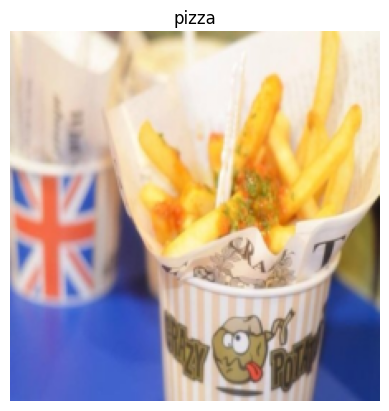

In [99]:
# Let's visualize an image to compare its size to our model requirements
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [100]:
img.shape

torch.Size([3, 224, 224])

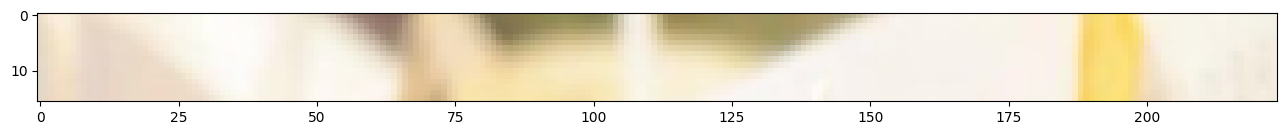

In [101]:
# To replicate turning an input image into patches, let's first try to plot a single row from an image
img_permuted = img.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permuted[:patch_size,:,:])

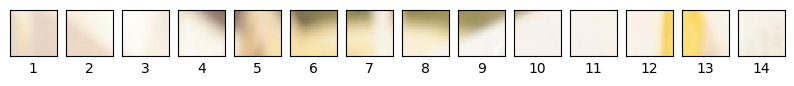

In [102]:
# Now let's turn this row into patches
img_size = 224
patch_size = 16
num_of_patches = int(img_size / patch_size)

if img_size % patch_size == 0:
  fig, axis = plt.subplots(nrows = 1,
                          ncols = num_of_patches,
                          sharex=True,
                          sharey = True,
                          figsize = (10, 10))

  for i, patch in enumerate(range(0, img_size, patch_size)):
    axis[i].imshow(img_permuted[:patch_size, patch : patch + patch_size, :])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])
else:
  print(f'Image size of {img_size} is not divisible by patch size of {patch_size}')

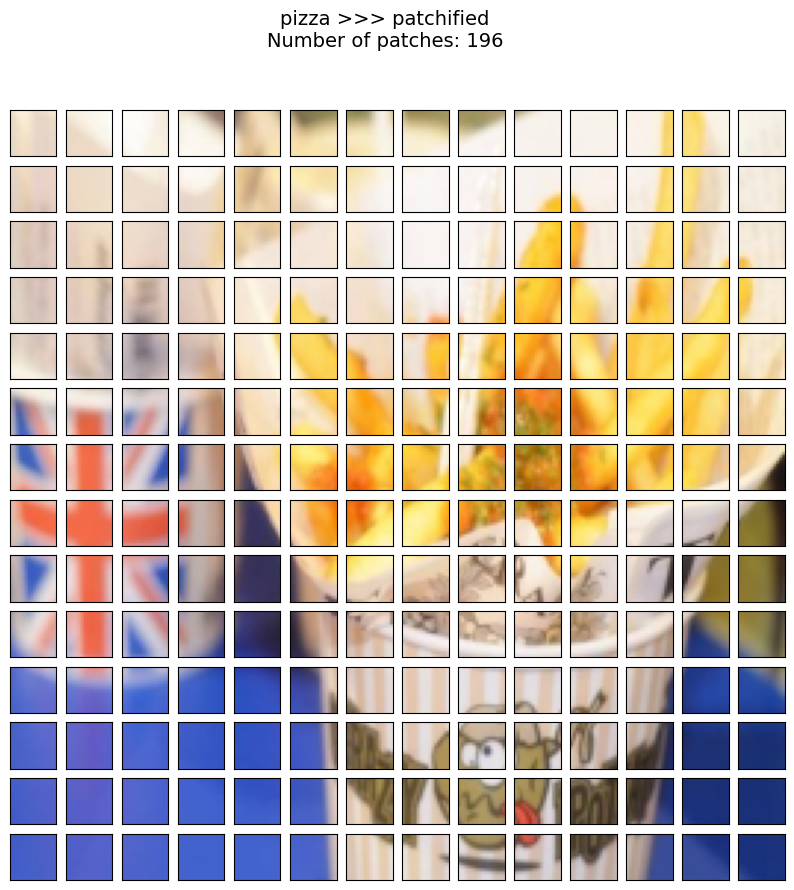

In [103]:
# Now for the entire image
height = 224
width = 224
patch_size = 16
num_of_patches_h = int(height / patch_size)
num_of_patches_w = int(width / patch_size)

if height % patch_size == 0 and width % patch_size == 0:
  fig, axis = plt.subplots(nrows = num_of_patches_h,
                          ncols = num_of_patches_w,
                          sharex=True,
                          sharey = True,
                          figsize = (10,10))

  for i, patch_h in enumerate(range(0, height, patch_size)):
    for j, patch_w in enumerate(range(0, width, patch_size)):
      axis[i,j].imshow(img_permuted[patch_h : patch_h + patch_size, patch_w : patch_w + patch_size, :])
      axis[i,j].set_xticks([])
      axis[i,j].set_yticks([])
      suptitle = f'{class_names[label]} >>> patchified\nNumber of patches: {num_of_patches_h*num_of_patches_w}'
      fig.suptitle(suptitle, fontsize = 14)
else:
  print(f'Image size of {img_size} is not divisible by patch size of {patch_size}')

## Turning patches into patch embeddings

As described in the research paper, we can turn our patches into patch embeddings using a convolutional layer, and then flattening these embeddings and passing them as the input. The Conv2D layer will create patches of learnable feature maps, and the Flatten layer will flatten these patches and turn them into a 1-D input vector.

In [104]:
# Creating the conv2d layer
from torch import nn

PATCH_SIZE = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels = 768,
                   stride = PATCH_SIZE,
                   kernel_size = PATCH_SIZE,
                   padding = 0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [105]:
# Passing an image through the conv2d layer
img_out_conv = conv2d(img.unsqueeze(0))
print(f'{img_out_conv.shape} -> (batch, embedding size, Feature map (embedding) Height, Feature map (embedding) Width)')

torch.Size([1, 768, 14, 14]) -> (batch, embedding size, Feature map (embedding) Height, Feature map (embedding) Width)


Showing random feature maps: [631, 609, 61, 3, 463]


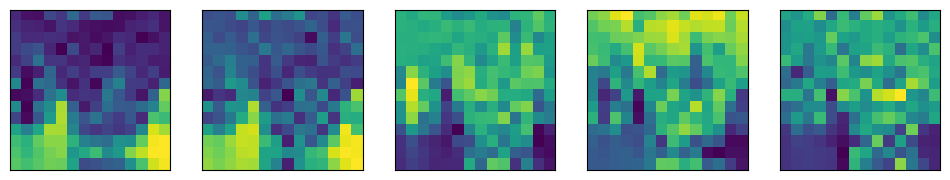

In [106]:
# Plotting random feature maps (embeddings) from our patched image
import random
random_idx = random.sample(range(0, 768), k = 5)
print(f'Showing random feature maps: {random_idx}')

fig, axis = plt.subplots(nrows = 1,
                         ncols = 5,
                         figsize = (12,12))

for i, idx in enumerate(random_idx):
  conv_feature_maps = img_out_conv[:, idx, :, :]
  axis[i].imshow(conv_feature_maps.squeeze(0).detach().numpy())
  axis[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

**These random patches are learnable representations of the image we passed through the conv2d layer**

In [107]:
img_out_conv.shape

torch.Size([1, 768, 14, 14])

This is the shape of the image after passing through the conv2d layer. We need the input to be of shape (1, 196, 768) (patch_size (equals 1 in our example), number_of_patch_embeddings, size_of_embedding). i.e. we need to flatten the patches into a sequence to satisfy the requirements of the ViT input.

In [108]:
# Now we'll flatten each embedding from the patched image using nn.Flatten()
flatten_layer = nn.Flatten(start_dim = 2, end_dim = -1)
# Passing the image through the Flatten layer
flattened_img = flatten_layer(img_out_conv)
flattened_img.shape

torch.Size([1, 768, 196])

In [109]:
# Manipulating dimensions to get the desired shape
flattened_img = flattened_img.permute(0,2,1)
flattened_img.shape

torch.Size([1, 196, 768])

Finally we can see how we went from a raw input 2D image (224, 224) into a 1D sequence of patch embeddings of shape (1, 196, 768)

Plotting three random falttened patches of indexes: [628, 466, 450]


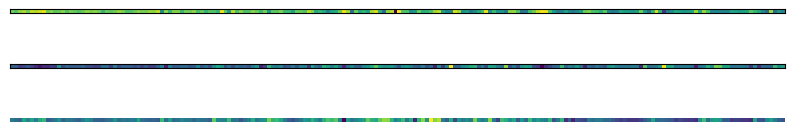

In [110]:
# Let's visualize a random pick of 3 flattened patches
random_idx = random.sample(range(0,768), k = 3)
print(f'Plotting three random falttened patches of indexes: {random_idx}')

fig, axis = plt.subplots(nrows = 3, ncols = 1, figsize = (10,2))
plt.axis(False)
for i, idx in enumerate(random_idx):
  flattened_patch = flattened_img[:,:,idx]
  axis[i].imshow(flattened_patch.detach().numpy())
  axis[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

## Putting it all together

In [111]:
# Now let's create a single class that will handle creating patch embeddings from input images for the ViT-Base
class PatchEmbedding(nn.Module):
  """
  Transforms a 2D input image into a 1D vector of patch embeddings.

  Serves as data preparation for the ViT-Base/16 transformer.

  Args:
    - in_channels: (int) the number of channels in the input image (default = 3).
    - embedding_size: (int) the size of the flattened input embedding to the ViT (default = 768).
    - patch_size: (int) the size of patches created from the image (default = 16).
  """
  # Defining the contructor
  def __init__(self,
               in_channels: int = 3,
               embedding_size: int = 768,
               patch_size: int = 16):
    super().__init__()
    # The patch embedding creator sequential block
    self.patch_creator = nn.Sequential(
        # The convolutional layer the will create the patch embeddings
        nn.Conv2d(in_channels = in_channels,
                  out_channels = embedding_size,
                  kernel_size = patch_size,
                  stride = patch_size,
                  padding = 0),
        # The flattening layer that will flatten the patch embedding into a 1D vector
        nn.Flatten(start_dim = 2,
                   end_dim = 3)
    )

  # Defining the forward mathod
  def forward(self, x):
    # Checking for image and patch size mismatching
    img_shape = x.shape[-1]
    if img_shape % patch_size == 0:
      output_img = self.patch_creator(x)
      # Returning the permuted image to match the requirements of the ViT input
      return output_img.permute(0,2,1) # permute to (batch_size, patch_size, embedding_size)
    else:
      print(f'Could not create patches because the image size of {img_shape} is not divisible by the patch size of {patch_size}')

In [112]:
# Testing out the patch embeddings creator class
torch.manual_seed(42)
torch.cuda.manual_seed(42)

patchify_img = PatchEmbedding(in_channels = 3,
                              embedding_size = 768,
                              patch_size = 16)

batched_img = img.unsqueeze(0)

print(f'Input image shape: {batched_img.shape}')
patch_embedded_img = patchify_img(batched_img)
print(f'Patch embedded image shape: {patch_embedded_img.shape}')

Input image shape: torch.Size([1, 3, 224, 224])
Patch embedded image shape: torch.Size([1, 196, 768])
